In [180]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
import scipy.stats as stats
from scipy.stats import ttest_ind







In [181]:
from pathlib import Path
import pandas as pd


user = 'omarlodhi'

figure_path = f'/Users/{user}/Downloads/UVAmacro-main/post_4/figures'


# Define the path to the directory containing the CSV files
data_path = Path(f'/Users/{user}/Downloads/UVAmacro-main/post_4/data')


df_OIS_swaps = pd.read_csv(f'{data_path}/OIS_swap_rates.csv')

df_treasury_yields = pd.read_csv(f'{data_path}/treasury_yields.csv')

df_tp = pd.read_csv(f'{data_path}/ACM.csv')

df_tp = df_tp[['Date', 'ACMTP10']]

df_tp.rename(columns={'ACMTP10': '10yr_tp'}, inplace=True)

df_tp['Date'] = pd.to_datetime(df_tp['Date'])

df_OIS_swaps['Date'] = pd.to_datetime(df_OIS_swaps['Date'])

df_treasury_yields['Date'] = pd.to_datetime(df_treasury_yields['Date'])

df_total = pd.merge(df_OIS_swaps, df_treasury_yields, on='Date', how='inner')

df_total = pd.merge(df_total, df_tp, on='Date', how='inner')

df_total.rename(columns={'7yr_yield ': '7yr_yield'}, inplace=True)
df_total.sort_values(by='Date', ascending=True, inplace=True)
df_total.reset_index(drop=True, inplace=True)

df_total['10yr_tp'] = df_total['10yr_tp']*100

df_total['2yr_OIS_swap'] = df_total['2yr_OIS_swap']*1000
df_total['10yr_OIS_swap'] = df_total['10yr_OIS_swap']*1000


print(df_total.columns)



Index(['Date', '3m_OIS_swap', '6m_OIS_swap', '1yr_OIS_swap', '2yr_OIS_swap',
       '3yr_OIS_swap', '5yr_OIS_swap', '7yr_OIS_swap', '10yr_OIS_swap',
       '10yr_yield', '1yr_yield', '2yr_yield', '5yr_yield', '30yr_yield',
       '20yr_yield', '3yr_yield', '7yr_yield', '10yr_tp'],
      dtype='object')


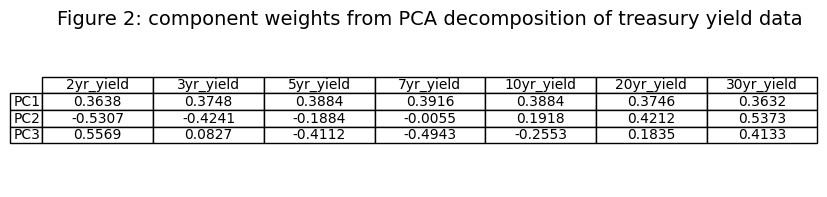

In [182]:
# figure 2 

# Define the function to plot PCA component weights as a table
def plot_pca_component_weights(pca, feature_names, title="PCA Component Weights", figure_path=None):
    """
    Plots a table of PCA component weights and saves it to a file if figure_path is provided.
    
    Parameters:
    pca: Fitted PCA object
    feature_names: List of feature names corresponding to components
    title: Custom title for the table
    figure_path: Path to save the figure (optional)
    """
    component_weights = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])
    


    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=component_weights.round(4).values,
             colLabels=component_weights.columns,
             rowLabels=component_weights.index,
             cellLoc='center', loc='center')
    
    plt.title(title, fontsize=14)

    # Save to file if figure_path is specified
    if figure_path:
        plt.savefig(figure_path)

    plt.show()
    
# Define PCA columns
pca_columns = ['2yr_yield', '3yr_yield', '5yr_yield', '7yr_yield', '10yr_yield', '20yr_yield', '30yr_yield']

# Standardize the data
df_pca = df_total[pca_columns].dropna()  # Drop NaN values to ensure PCA works
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Perform PCA
pca = PCA(n_components=3)
pc_scores = pca.fit_transform(df_scaled)  # Get PC1, PC2 values

# Merge PC scores (PC1, PC2) back into df_total
df_total['PC1'] = pc_scores[:, 0]
df_total['PC2'] = pc_scores[:, 1]
df_total['PC3'] = pc_scores[:, 2]



# Define figure path (ensure the directory exists)
figure_with_name = os.path.join(figure_path, 'figure_2.jpg')

# Plot and save PCA component weights
plot_pca_component_weights(pca, pca_columns, title="Figure 2: component weights from PCA decomposition of treasury yield data", figure_path=figure_with_name)





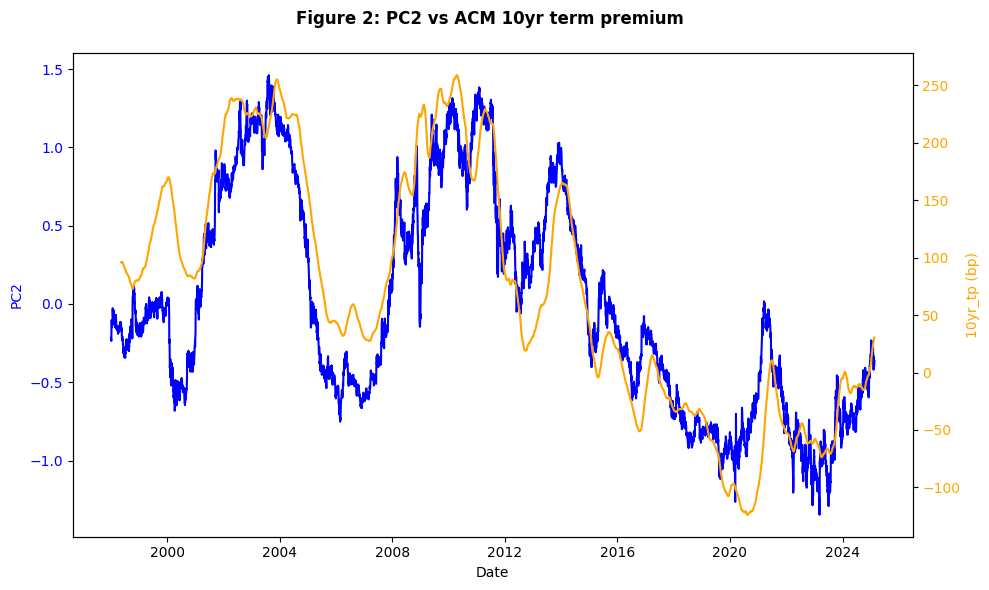

In [183]:
# figure 3


fig, ax1 = plt.subplots(figsize=(10, 6))

df_total['PC2_sm'] = df_total['PC2'].rolling(window=90).mean()
df_total['10yr_tp_sm'] = df_total['10yr_tp'].rolling(window=90).mean()

# Plot PC2 on primary y-axis
ax1.plot(df_total['Date'], df_total['PC2'], label='PC2', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('PC2', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df_total['Date'], df_total['10yr_tp_sm'], label='10yr_tp', color='orange')
ax2.set_ylabel('10yr_tp (bp)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and formatting
plt.title('Figure 2: PC2 vs ACM 10yr term premium \n', fontweight='bold')
fig.tight_layout()
fig.savefig(f'{figure_path}/figure_3.jpg', format='jpeg', bbox_inches='tight')
plt.show()





89     1998-05-12
90     1998-05-13
91     1998-05-14
92     1998-05-15
93     1998-05-18
          ...    
6772   2025-02-11
6773   2025-02-12
6774   2025-02-13
6775   2025-02-14
6776   2025-02-18
Name: Date, Length: 6688, dtype: datetime64[ns]
PCA loadings table saved as: /Users/omarlodhi/Downloads/UVAmacro-main/post_4/figures/figure_3.jpg


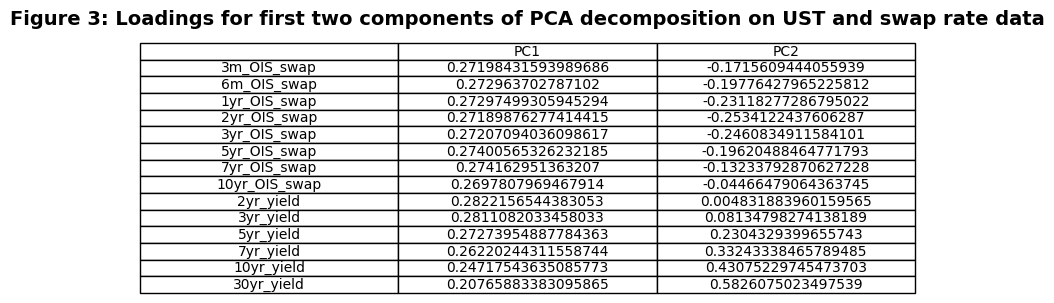

In [185]:
# figure 4
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print(df_total.Date)


df_total['spread_10yr_2yr'] = df_total['10yr_OIS_swap'] - df_total['10yr_yield'] - (df_total['2yr_OIS_swap'] - df_total['2yr_yield'])
# Spread of spreads for each tenor
df_total['spread_10yr_1yr'] = df_total['10yr_OIS_swap'] - df_total['10yr_yield'] - (df_total['1yr_OIS_swap'] - df_total['1yr_yield'])


pca_columns = [
    '3m_OIS_swap', '6m_OIS_swap', '1yr_OIS_swap', '2yr_OIS_swap', 
    '3yr_OIS_swap', '5yr_OIS_swap', '7yr_OIS_swap', '10yr_OIS_swap',
    '2yr_yield', '3yr_yield', '5yr_yield', 
    '7yr_yield', '10yr_yield', '30yr_yield'
]






# Drop missing data for these columns
df_pca = df_total[pca_columns].dropna()

# Optional: Drop missing values in the entire dataframe (but avoid removing these rows prematurely)
df_total.dropna(inplace=True)

# Step 2: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Step 3: Perform PCA (number of components equal to the number of variables)
n_components = 2  # Set the number of components equal to the number of variables
pca = PCA(n_components=n_components)
pc_scores = pca.fit_transform(df_scaled)

# Step 4: Merge the PCA components into the original dataframe as new columns
for i in range(n_components):
    df_total[f'PC{i+1}'] = pc_scores[:, i]




# Optional: Drop missing values from the original dataframe (if any introduced by PCA scores)
df_total.dropna(inplace=True)

# Step 5: Extract Loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(n_components)], index=pca_columns)



# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')

# Create table
table_data = loadings.reset_index().values  # Convert DataFrame to list format for table
column_labels = ['','PC1', 'PC2']  # Column names

table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')
plt.title('Figure 3: Loadings for first two components of PCA decomposition on UST and swap rate data', fontsize=14, fontweight='bold', pad=20)

# Save table as JPEG
table_path = os.path.join(figure_path, 'figure_3.jpg')
plt.savefig(table_path, dpi=300, bbox_inches='tight')

print(f"PCA loadings table saved as: {table_path}")







/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_47211/3490947719.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['spread2'] = (df_filtered['10yr_OIS_swap'] - df_filtered['10yr_yield'])


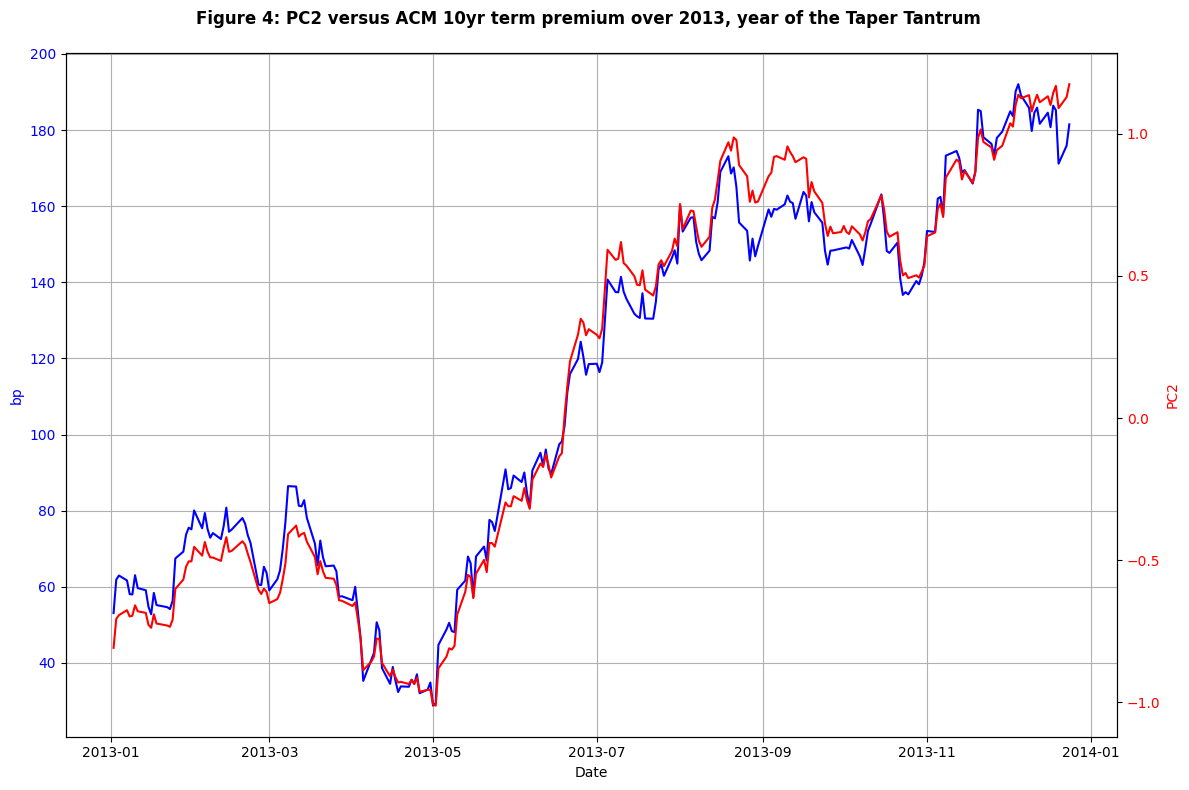

In [186]:
#figure 4 

# Filter for 2007-2009

df_total['PC2_sm'] = df_total['PC2'].rolling(window=30).mean()
df_filtered = df_total[(df_total['Date'] >= '2013-01-01') & (df_total['Date'] <= '2013-12-25')]


# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))
df_filtered['spread2'] = (df_filtered['10yr_OIS_swap'] - df_filtered['10yr_yield']) 


# Plot PC2 on the first y-axis (ax1)
ax1.plot(df_filtered['Date'], df_filtered['10yr_tp'], color='blue', label='other')
ax1.set_xlabel('Date')
ax1.set_ylabel('bp', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot PC1 on the second y-axis (ax2)
ax2.plot(df_filtered['Date'], df_filtered['PC2'], color='red', label='PC2')
ax2.set_ylabel('PC2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

#ax2.axvspan('2025-02-22', '2013-11-27', color='grey', alpha=0.3)

# Title and grid
plt.title('Figure 4: PC2 versus ACM 10yr term premium over 2013, year of the Taper Tantrum \n', fontweight = 'bold')
ax1.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig(f'{figure_path}/figure_4.jpg', format='jpeg', bbox_inches='tight')

plt.show()


In [192]:

#data prep for figures 5 and 6

# Calculate returns for the 10-year and 2-year OIS swaps
df_total['10yr_returns'] = np.log(df_total['10yr_OIS_swap']/ df_total['10yr_OIS_swap'].shift(1))
df_total['2yr_returns'] = np.log(df_total['2yr_OIS_swap']/ df_total['2yr_OIS_swap'].shift(1))

# Calculate rolling volatility for both 10-year and 2-year returns (30-day rolling window)
df_total['10yr_vol_30'] = df_total['10yr_returns'].rolling(window=132).std()
df_total['2yr_vol_30'] = df_total['2yr_returns'].rolling(window=132).std()

df_total['10yr_vol_504'] = df_total['10yr_returns'].rolling(window=504).std()
df_total['2yr_vol_504'] = df_total['2yr_returns'].rolling(window=504).std()

df_total['10yr_vol_132'] = df_total['10yr_returns'].rolling(window=132).std()
df_total['2yr_vol_132'] = df_total['2yr_returns'].rolling(window=132).std()


# Difference in volatility (negative of the difference)
df_total['vol_diff_30'] = - (df_total['10yr_vol_30'] - df_total['2yr_vol_30'])

# Shift vol_diff to represent the forward-looking period (30 days ahead)
df_total['vol_diff_ahead_30'] = df_total['vol_diff_30'].shift(-124)

df_total['vol_diff_calendar'] = (df_total['10yr_vol_132'].shift(-132) - df_total['10yr_vol_504'].shift(-504))



# Compute rolling changes in PC2 for different periods
df_total['PC2_5d_change'] = df_total['PC2'].diff(5)
df_total['PC2_14d_change'] = df_total['PC2'].diff(14)
df_total['PC2_22d_change'] = df_total['PC2'].diff(22)

# Compute rolling mean and standard deviation for z-score calculation
rolling_window = 500  # Two years of trading days
df_total['PC2_5d_zscore'] = (df_total['PC2_5d_change'] - df_total['PC2_5d_change'].rolling(rolling_window, min_periods=1).mean()) / df_total['PC2_5d_change'].rolling(rolling_window, min_periods=1).std()
df_total['PC2_14d_zscore'] = (df_total['PC2_14d_change'] - df_total['PC2_14d_change'].rolling(rolling_window, min_periods=1).mean()) / df_total['PC2_14d_change'].rolling(rolling_window, min_periods=1).std()
df_total['PC2_22d_zscore'] = (df_total['PC2_22d_change'] - df_total['PC2_22d_change'].rolling(rolling_window, min_periods=1).mean()) / df_total['PC2_22d_change'].rolling(rolling_window, min_periods=1).std()




/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_47211/4279707984.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=category_col, y='vol_diff_ahead_30', data=df_plot, palette=palette, ax=ax,
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_47211/4279707984.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_plot.groupby(category_col)['vol_diff_ahead_30'].mean().reindex(['-1 to -2', '< -2'])
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_47211/4279707984.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and s

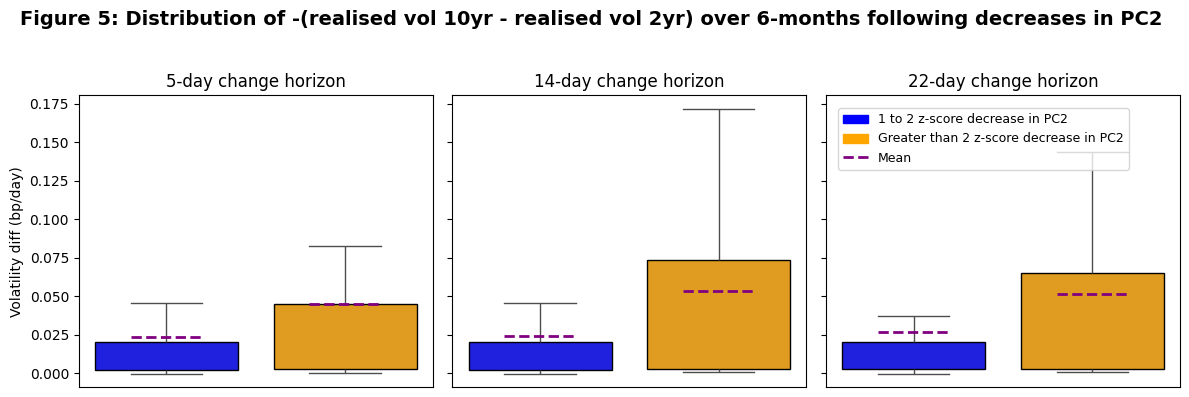

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Copy DataFrame
df_plot = df_total.copy()

# Define categories for z-scores (Only '< -2' and '-1 to -2')
df_plot['category_5d'] = pd.cut(df_plot['PC2_5d_zscore'], bins=[-float('inf'), -2, -1], labels=['< -2', '-1 to -2'])
df_plot['category_14d'] = pd.cut(df_plot['PC2_14d_zscore'], bins=[-float('inf'), -2, -1], labels=['< -2', '-1 to -2'])
df_plot['category_22d'] = pd.cut(df_plot['PC2_22d_zscore'], bins=[-float('inf'), -2, -1], labels=['< -2', '-1 to -2'])

# Define consistent color mapping
palette = {'-1 to -2': 'blue', '< -2': 'orange'}

# Set up figure and axes (side by side) - Increased height
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Function to plot boxplots with per-category mean lines
def plot_boxplot(ax, category_col, title):
    # Plot boxplot without median line
    sns.boxplot(x=category_col, y='vol_diff_ahead_30', data=df_plot, palette=palette, ax=ax, 
                order=['-1 to -2', '< -2'], showfliers=False,
                medianprops=dict(visible=False),
                boxprops=dict(edgecolor='black'))  # Keep only box edges

    ax.set_title(title, fontsize=12)

    # Compute means for each category in the correct order
    means = df_plot.groupby(category_col)['vol_diff_ahead_30'].mean().reindex(['-1 to -2', '< -2'])

    # Add horizontal mean lines just inside each category box
    for i, category in enumerate(means.index):
        ax.hlines(y=means[category], xmin=i - 0.2, xmax=i + 0.2, color='purple', linestyle='--', linewidth=2)  # Short line within the box

# Plot each boxplot
plot_boxplot(axes[0], 'category_5d', '5-day change horizon')
plot_boxplot(axes[1], 'category_14d', '14-day change horizon')
plot_boxplot(axes[2], 'category_22d', '22-day change horizon')

# Create custom legend
legend_patches = [
    mpatches.Patch(color='blue', label='1 to 2 z-score decrease in PC2'),
    mpatches.Patch(color='orange', label='Greater than 2 z-score decrease in PC2'),
    mlines.Line2D([], [], color='purple', linestyle='--', linewidth=2, label='Mean')
]

# Move legend into empty space at the top-right
fig.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(0.95, 0.75), fontsize=9)

# Set an overall bold title and move it to the very top
fig.suptitle("Figure 5: Distribution of -(realised vol 10yr - realised vol 2yr) over 6-months following decreases in PC2 \n", fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.85)  # Adjust top margin to move title higher

# Clean up labels
for ax in axes:
    ax.grid(False)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_xlabel('')  # Remove x-axis labels

axes[0].set_ylabel('Volatility diff (bp/day)')

plt.tight_layout()

# Save the figure
plt.savefig(f"{figure_path}/figure_5.jpg", bbox_inches='tight')

# Show plot
plt.show()


